In [1]:
#pip install dask
#pip install dask-ml
import plotly.io as pio
#pio.renderers.default='notebook'

In [2]:
#!python -m pip install "dask[dataframe]" --upgrade
#!pip install plotly
#!pip install statsmodels
#!pip install seaborn
#!pip install das_ml


In [3]:
import dask
dask.config.set({'dataframe.query-planning-warning': False})
import dask.dataframe as dd
from time import time
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
# Set the style for Seaborn
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from time import time
import multiprocessing as mp
from time import time
from dask.distributed import Client
from dask_ml.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Data Processing

In [4]:
%%time
## Load full trip data
data_full = dd.read_csv("data/Trips_Full Data.csv", assume_missing=True)
#load trip data by distance
data_dist = dd.read_csv("data/Trips_by_Distance.csv", assume_missing=True, dtype={'County Name': 'object', 'State Postal Code': 'object'})

CPU times: total: 93.8 ms
Wall time: 118 ms


In [5]:
# Check for missing values
missing_full = data_full.isnull().sum().compute()
missing_dist = data_dist.isnull().sum().compute()

In [6]:
#number missing values per variable
print("Missing values in full trip data:")
print(missing_full)

print("\nMissing values in trip data by distance:")
print(missing_dist)

Missing values in full trip data:
Month of Date                 0
Week of Date                  0
Year of Date                  0
Level                         0
Date                          0
Week Ending Date              0
Trips <1 Mile                 0
People Not Staying at Home    0
Population Staying at Home    0
Trips                         0
Trips 1-25 Miles              0
Trips 1-3 Miles               0
Trips 10-25 Miles             0
Trips 100-250 Miles           0
Trips 100+ Miles              0
Trips 25-100 Miles            0
Trips 25-50 Miles             0
Trips 250-500 Miles           0
Trips 3-5 Miles               0
Trips 5-10 Miles              0
Trips 50-100 Miles            0
Trips 500+ Miles              0
dtype: int64

Missing values in trip data by distance:
Level                                 0
Date                                  0
State FIPS                          901
State Postal Code                   901
County FIPS                       46852
County 

In [7]:
%%time
# Drop columns with more than 50% missing entries
threshold = 0.5
columns_to_drop_full = missing_full[missing_full > threshold * len(data_full)].index
columns_to_drop_dist = missing_dist[missing_dist > threshold * len(data_dist)].index

data_full = data_full.drop(columns=columns_to_drop_full)
data_dist = data_dist.drop(columns=columns_to_drop_dist)

CPU times: total: 5.25 s
Wall time: 7.72 s


In [8]:
# Drop rows with missing data
data_full = data_full.dropna().reset_index()
data_dist = data_dist.dropna().reset_index()

In [9]:
%%time
# Display info after dropping columns and rows
print("\nInfo after dropping columns and rows:")
print("Full trip data:")
print(data_full.compute().info())

print("\nTrip data by distance:")
print(data_dist.compute().info())


Info after dropping columns and rows:
Full trip data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   index                       7 non-null      int64  
 1   Month of Date               7 non-null      string 
 2   Week of Date                7 non-null      string 
 3   Year of Date                7 non-null      float64
 4   Level                       7 non-null      string 
 5   Date                        7 non-null      string 
 6   Week Ending Date            7 non-null      string 
 7   Trips <1 Mile               7 non-null      float64
 8   People Not Staying at Home  7 non-null      float64
 9   Population Staying at Home  7 non-null      float64
 10  Trips                       7 non-null      float64
 11  Trips 1-25 Miles            7 non-null      float64
 12  Trips 1-3 Miles             7 non-null   

CPU times: total: 8.34 s
Wall time: 11.5 s


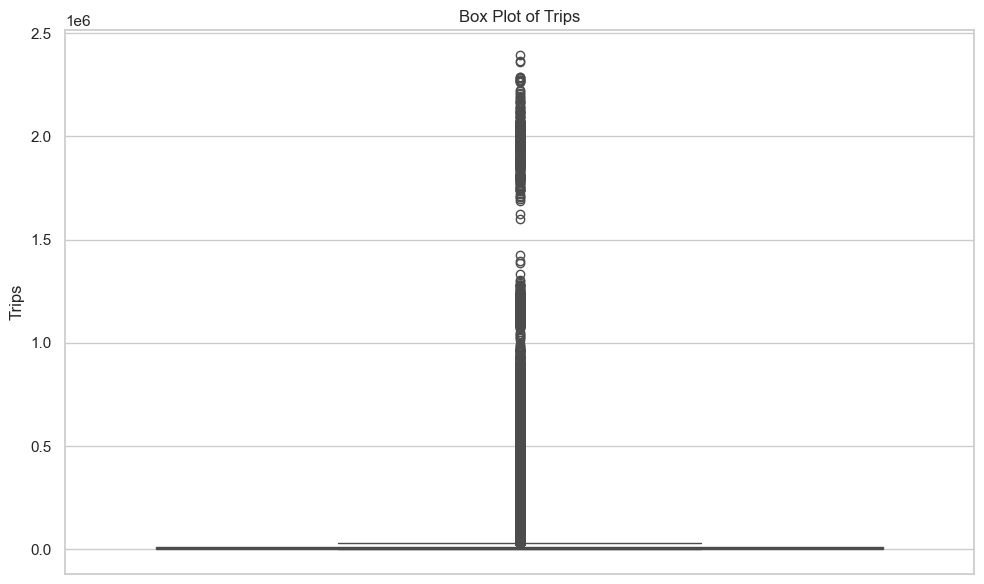

In [10]:
%%time
#compute the data
computed_data = data_dist.compute()

# Create box plot using Matplotlib and Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(y=computed_data['Population Staying at Home'])
plt.title('Box Plot of Trips')
plt.ylabel('Trips')
plt.tight_layout()

##### Check if there are any outliers

There are some outliers in the data. To handle outleirs, we will apply winsorization (https://www.geeksforgeeks.org/winsorization/)

#### 1A - Data Aggregation (People staying at home)

In [11]:
def process_data_dask(file_path, num_workers):
    # Set the Dask scheduler and number of workers
    dask.config.set(scheduler='processes', num_workers=num_workers)

    # Read CSV file into a Dask DataFrame
    start = time()
    air = dd.read_csv(file_path, assume_missing=True, dtype={'County Name': 'object', 'State Postal Code': 'object'})
    #process the data
    # Drop columns with more than 50% missing entries
    missing = air.isnull().sum().compute()
    threshold = 0.5
    columns_to_drop = missing[missing > threshold * len(air)].index
    
    air = air.drop(columns=columns_to_drop)
    air = air.dropna().reset_index().compute()
    # Winsorize outliers for numeric columns
    numeric_columns = air.select_dtypes(include='number').columns
    #air[numeric_columns] = air[numeric_columns].map(winsorize, axis=0)

    # Drop rows with missing values after winsorization
    air = air.dropna().reset_index(drop=True)
    read_time = round(time() - start, 2)

    # Perform groupby and compute mean
    start = time()
    by_week = air.groupby('Week')['Population Staying at Home'].mean()
    result = round(by_week, 2)
    groupby_time = round(time() - start, 2)

    return result, read_time, groupby_time

def process_data_sequential(file_path):
    dask.config.set(scheduler='synchronous')
    # Read CSV file into a Dask DataFrame
    start = time()
    air = dd.read_csv(file_path, assume_missing=True, dtype={'County Name': 'object', 'State Postal Code': 'object'})
    #process the data
    # Drop columns with more than 50% missing entries
    missing = air.isnull().sum().compute()
    threshold = 0.5
    columns_to_drop = missing[missing > threshold * len(air)].index
    
    air = air.drop(columns=columns_to_drop)
    air = air.dropna().reset_index().compute()
    # Winsorize outliers for numeric columns
    numeric_columns = air.select_dtypes(include='number').columns
    #air[numeric_columns] = air[numeric_columns].map(winsorize, axis=0)

    # Drop rows with missing values after winsorization
    air = air.dropna().reset_index(drop=True)
    read_time = round(time() - start, 2)

    # Perform groupby and compute mean
    start = time()
    by_week = air.groupby('Week')['Population Staying at Home'].mean()
    result = round(by_week, 2)
    groupby_time = round(time() - start, 2)

    return result, read_time, groupby_time

def main_dask():
    file_path = "data/Trips_by_Distance.csv"
    # Process data sequentially using Dask
    result_seq, read_time_seq, groupby_time_seq = process_data_sequential(file_path)
    total_time_seq_1a = read_time_seq + groupby_time_seq
    print("Results with sequential processing:")
    display(result_seq)
    print("Total Time: {} seconds".format(total_time_seq_1a))
    print("Read Time: {} seconds".format(read_time_seq))
    print("Groupby Time: {} seconds".format(groupby_time_seq))
    print("Results with 10 processors:")
    # Process data using Dask with 10 processors
    result_10, read_time_10, groupby_time_10 = process_data_dask(file_path, num_workers=10)
    total_time_dask_10_1a = read_time_10 + groupby_time_10

    print("\nResults with 10 processors:")
    display(result_10)
    print("Total Time: {} seconds".format(total_time_dask_10_1a))
    print("Read Time: {} seconds".format(read_time_10))
    print("Groupby Time: {} seconds".format(groupby_time_10))

    # Process data using Dask with 20 processors
    result_20, read_time_20, groupby_time_20 = process_data_dask(file_path, num_workers=20)
    total_time_dask_20_1a = read_time_20 + groupby_time_20

    print("\nResults with 20 processors:")
    display(result_20)
    print("Total Time: {} seconds".format(total_time_dask_20_1a))
    print("Read Time: {} seconds".format(read_time_20))
    print("Groupby Time: {} seconds".format(groupby_time_20))
#    #return one aggregation result for visualization
    return result_20, total_time_dask_10_1a, total_time_dask_20_1a, total_time_seq_1a

if __name__ == '__main__':
    results, total_time_dask_10_1a, total_time_dask_20_1a, total_time_seq_1a = main_dask()

Results with sequential processing:


Week
0.0     20976.79
1.0     20071.31
2.0     19897.34
3.0     19889.44
4.0     20096.31
5.0     19757.43
6.0     19599.07
7.0     20033.60
8.0     19741.67
9.0     20043.10
10.0    19826.90
11.0    20264.39
12.0    20632.23
13.0    20792.38
14.0    21064.02
15.0    21375.30
16.0    20066.29
17.0    19666.74
18.0    20020.24
19.0    19679.55
20.0    19881.39
21.0    20060.82
22.0    19897.75
23.0    20503.63
24.0    20571.77
25.0    20088.39
26.0    20823.99
27.0    20249.93
28.0    20038.48
29.0    20758.97
30.0    20662.34
31.0    20285.02
32.0    19052.69
33.0    18745.05
34.0    18890.03
35.0    20627.34
36.0    19918.28
37.0    20077.21
38.0    20648.27
39.0    21323.44
40.0    21132.91
41.0    21656.94
42.0    21958.42
43.0    21998.57
44.0     7465.21
Name: Population Staying at Home, dtype: float64

Total Time: 32.17 seconds
Read Time: 32.11 seconds
Groupby Time: 0.06 seconds
Results with 10 processors:

Results with 10 processors:


Week
0.0     20976.79
1.0     20071.31
2.0     19897.34
3.0     19889.44
4.0     20096.31
5.0     19757.43
6.0     19599.07
7.0     20033.60
8.0     19741.67
9.0     20043.10
10.0    19826.90
11.0    20264.39
12.0    20632.23
13.0    20792.38
14.0    21064.02
15.0    21375.30
16.0    20066.29
17.0    19666.74
18.0    20020.24
19.0    19679.55
20.0    19881.39
21.0    20060.82
22.0    19897.75
23.0    20503.63
24.0    20571.77
25.0    20088.39
26.0    20823.99
27.0    20249.93
28.0    20038.48
29.0    20758.97
30.0    20662.34
31.0    20285.02
32.0    19052.69
33.0    18745.05
34.0    18890.03
35.0    20627.34
36.0    19918.28
37.0    20077.21
38.0    20648.27
39.0    21323.44
40.0    21132.91
41.0    21656.94
42.0    21958.42
43.0    21998.57
44.0     7465.21
Name: Population Staying at Home, dtype: float64

Total Time: 42.18 seconds
Read Time: 42.12 seconds
Groupby Time: 0.06 seconds

Results with 20 processors:


Week
0.0     20976.79
1.0     20071.31
2.0     19897.34
3.0     19889.44
4.0     20096.31
5.0     19757.43
6.0     19599.07
7.0     20033.60
8.0     19741.67
9.0     20043.10
10.0    19826.90
11.0    20264.39
12.0    20632.23
13.0    20792.38
14.0    21064.02
15.0    21375.30
16.0    20066.29
17.0    19666.74
18.0    20020.24
19.0    19679.55
20.0    19881.39
21.0    20060.82
22.0    19897.75
23.0    20503.63
24.0    20571.77
25.0    20088.39
26.0    20823.99
27.0    20249.93
28.0    20038.48
29.0    20758.97
30.0    20662.34
31.0    20285.02
32.0    19052.69
33.0    18745.05
34.0    18890.03
35.0    20627.34
36.0    19918.28
37.0    20077.21
38.0    20648.27
39.0    21323.44
40.0    21132.91
41.0    21656.94
42.0    21958.42
43.0    21998.57
44.0     7465.21
Name: Population Staying at Home, dtype: float64

Total Time: 39.510000000000005 seconds
Read Time: 39.45 seconds
Groupby Time: 0.06 seconds


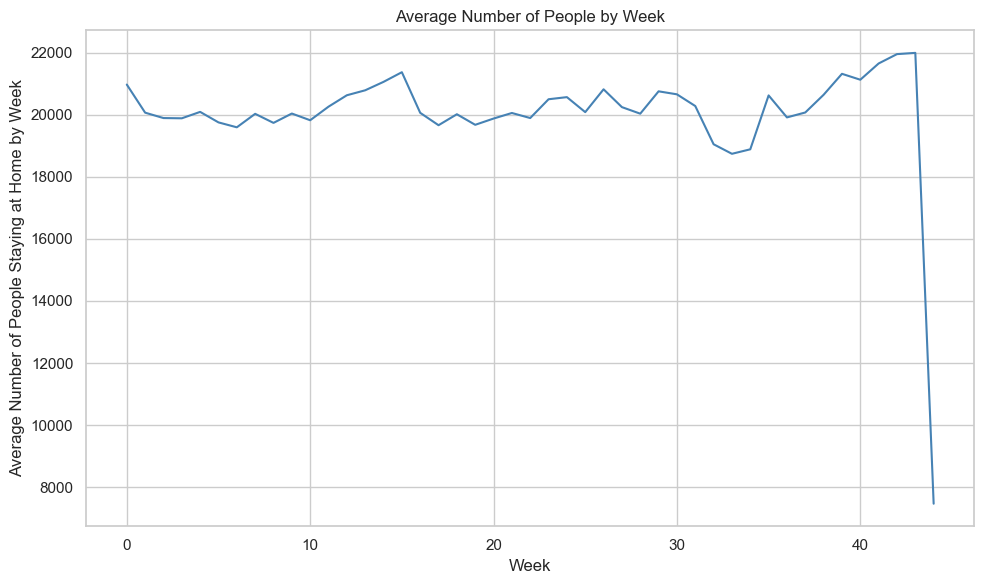

CPU times: total: 641 ms
Wall time: 756 ms


In [12]:
%%time
results_df = pd.DataFrame(results).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Week', y='Population Staying at Home', color='steelblue')
plt.title('Average Number of People by Week')
plt.xlabel('Week')
plt.ylabel('Average Number of People Staying at Home by Week')
plt.tight_layout()

# Show the plot
plt.show()

#### 1B - Data Aggregation (How far people travel)

In [13]:
# Function to read the data
def read_data(file_path):
    start = time()
    air = dd.read_csv(file_path, assume_missing=True , dtype={'County Name': 'object', 'State Postal Code': 'object'})
    #process the data
    # Drop columns with more than 50% missing entries
    missing = air.isnull().sum().compute()
    threshold = 0.5
    columns_to_drop = missing[missing > threshold * len(air)].index
    
    air = air.drop(columns=columns_to_drop)
    air = air.dropna().reset_index()
    # Winsorize outliers for numeric columns
    numeric_columns = air.select_dtypes(include='number').columns


    # Drop rows with missing values after winsorization
    air = air.dropna().reset_index(drop=True)
    
    read_time = round(time() - start, 2)
    return air, read_time

def group_week_dask(data, num_workers):
    dask.config.set(scheduler='processes', num_workers=num_workers)
    start = time()
    # Extracting week numbers from 'Week Ending Date' column
    data = data.assign(Week = lambda x: data['Week of Date'].str.extract('(\d+)'))
    # Group by 'Week' and calculate the mean for selected columns
    averages = data.groupby("Week")[['Trips 1-25 Miles',
                                      'Trips 1-3 Miles', 'Trips 10-25 Miles', 'Trips 100-250 Miles',
                                      'Trips 100+ Miles', 'Trips 25-100 Miles', 'Trips 25-50 Miles',
                                      'Trips 250-500 Miles', 'Trips 3-5 Miles', 'Trips 5-10 Miles',
                                      'Trips 50-100 Miles', 'Trips 500+ Miles']].mean()
    result = averages.compute()
    groupby_time = round(time() - start, 2)
    return result, groupby_time




def group_week_dask_sequential(data):
    dask.config.set(scheduler='synchronous')
    start = time()
    # Extracting week numbers from 'Week Ending Date' column
    data = data.assign(Week = lambda x: data['Week of Date'].str.extract('(\d+)'))
    # Group by 'Week' and calculate the mean for selected columns
    averages = data.groupby("Week")[['Trips 1-25 Miles',
                                      'Trips 1-3 Miles', 'Trips 10-25 Miles', 'Trips 100-250 Miles',
                                      'Trips 100+ Miles', 'Trips 25-100 Miles', 'Trips 25-50 Miles',
                                      'Trips 250-500 Miles', 'Trips 3-5 Miles', 'Trips 5-10 Miles',
                                      'Trips 50-100 Miles', 'Trips 500+ Miles']].mean()
    result = averages.compute()
    groupby_time = round(time() - start, 2)
    return result, groupby_time

def compare_performance(file_path):
    # Read data sequentially
    air_seq, read_time_seq = read_data(file_path)
    result_seq, groupby_time_seq = group_week_dask_sequential(air_seq)
    total_time_seq_1b = read_time_seq + groupby_time_seq

    print("Results with sequential processing:")
    display(round(result_seq))
    print("Total Time: {} seconds".format(total_time_seq_1b))
    print("Read Time: {} seconds".format(read_time_seq))
    print("Groupby Time: {} seconds".format(groupby_time_seq))

    # Read data using Dask with 10 processors
    air_dask_10, read_time_dask_10 = read_data(file_path)
    result_dask_10, groupby_time_dask_10 = group_week_dask(air_dask_10, num_workers=10)
    total_time_dask_10 = read_time_dask_10 + groupby_time_dask_10

    print("\nResults with Dask processing (10 processors):")
    display(round(result_dask_10))
    print("Total Time: {} seconds".format(total_time_dask_10))
    print("Read Time: {} seconds".format(read_time_dask_10))
    print("Groupby Time: {} seconds".format(groupby_time_dask_10))

    # Read data using Dask with 20 processors
    air_dask_20, read_time_dask_20 = read_data(file_path)
    result_dask_20, groupby_time_dask_20 = group_week_dask(air_dask_20, num_workers=20)
    total_time_dask_20 = read_time_dask_20 + groupby_time_dask_20

    print("\nResults with Dask processing (20 processors):")
    display(round(result_dask_20))
    print("Total Time: {} seconds".format(total_time_dask_20))
    print("Read Time: {} seconds".format(read_time_dask_20))
    print("Groupby Time: {} seconds".format(groupby_time_dask_20))
    #return dataframe for visualization
    return result_dask_20, total_time_dask_10, total_time_dask_20, total_time_seq_1b

if __name__ == '__main__':
    file_path = "data/Trips_Full Data.csv"
    results_1b, total_time_dask_10, total_time_dask_20, total_time_seq_1b = compare_performance(file_path)

Results with sequential processing:


,Trips 1-25 Miles,Trips 1-3 Miles,Trips 10-25 Miles,Trips 100-250 Miles,Trips 100+ Miles,Trips 25-100 Miles,Trips 25-50 Miles,Trips 250-500 Miles,Trips 3-5 Miles,Trips 5-10 Miles,Trips 50-100 Miles,Trips 500+ Miles
Week,,,,,,,,,,,,
32,1.015555e+09,369476657.0,231078511.0,6850130.0,12122473.0,88037455.0,69159131.0,1829242.0,181555834.0,233444464.0,18878323.0,3443101.0


Total Time: 9.6 seconds
Read Time: 9.45 seconds
Groupby Time: 0.15 seconds

Results with Dask processing (10 processors):


,Trips 1-25 Miles,Trips 1-3 Miles,Trips 10-25 Miles,Trips 100-250 Miles,Trips 100+ Miles,Trips 25-100 Miles,Trips 25-50 Miles,Trips 250-500 Miles,Trips 3-5 Miles,Trips 5-10 Miles,Trips 50-100 Miles,Trips 500+ Miles
Week,,,,,,,,,,,,
32,1.015555e+09,369476657.0,231078511.0,6850130.0,12122473.0,88037455.0,69159131.0,1829242.0,181555834.0,233444464.0,18878323.0,3443101.0


Total Time: 5.68 seconds
Read Time: 0.3 seconds
Groupby Time: 5.38 seconds

Results with Dask processing (20 processors):


,Trips 1-25 Miles,Trips 1-3 Miles,Trips 10-25 Miles,Trips 100-250 Miles,Trips 100+ Miles,Trips 25-100 Miles,Trips 25-50 Miles,Trips 250-500 Miles,Trips 3-5 Miles,Trips 5-10 Miles,Trips 50-100 Miles,Trips 500+ Miles
Week,,,,,,,,,,,,
32,1.015555e+09,369476657.0,231078511.0,6850130.0,12122473.0,88037455.0,69159131.0,1829242.0,181555834.0,233444464.0,18878323.0,3443101.0


Total Time: 13.77 seconds
Read Time: 8.99 seconds
Groupby Time: 4.78 seconds


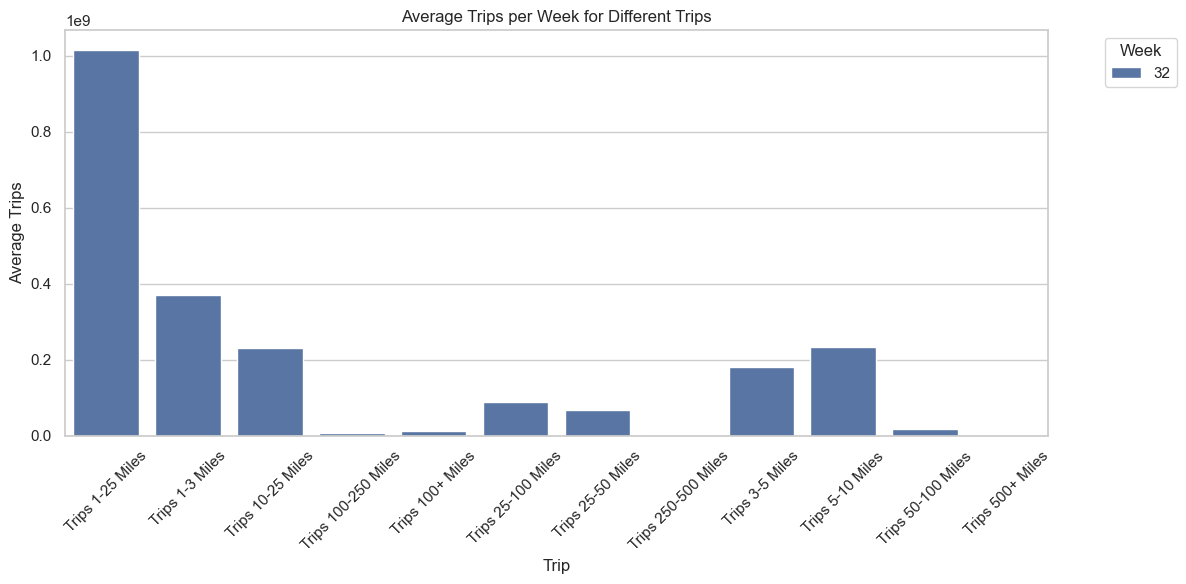

CPU times: total: 875 ms
Wall time: 1.09 s


In [14]:
%%time
melted_data = results_1b.reset_index().melt(id_vars='Week', var_name='Trip', value_name='Average Trips')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Trip', y='Average Trips', hue='Week', data=melted_data)
plt.title('Average Trips per Week for Different Trips')
plt.xlabel('Trip')
plt.ylabel('Average Trips')
plt.legend(title='Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate x-axis 
plt.tight_layout()
#show plot
plt.show()

#### 1 C - Filtering

In [95]:
import dask
import dask.dataframe as dd
from time import time

def read_data(file_path):
    #import data using Dask
    start_read_time = time()
    dtypes = {'County Name': 'object', 'State Postal Code': 'object', 'Number of Trips': 'float64',
       'Number of Trips 1-3': 'float64',
       'Number of Trips 10-25': 'float64',
       'Number of Trips 100-250': 'float64',
       'Number of Trips 25-50': 'float64',
       'Number of Trips 250-500': 'float64',
       'Number of Trips 3-5': 'float64',
       'Number of Trips 5-10': 'float64',
       'Number of Trips 50-100': 'float64',
       'Number of Trips <1': 'float64',
       'Number of Trips >=500': 'float64',
       'Population Not Staying at Home': 'float64',
       'Population Staying at Home': 'float64'}
    data = dd.read_csv(file_path, dtype=dtypes)
    end_read_time = time()
    read_time = round(end_read_time - start_read_time, 2)

    return data, read_time

def filter_data(data, num_workers=None):
    # Select analysis columns
    selected_columns = ['Date', 'Number of Trips 10-25', 'Number of Trips 50-100']
    data_selected = data[selected_columns]

    # Drop rows with missing entries
    data_selected = data_selected.dropna()

    # Record start time for filtering
    start_filter_time = time()

    # Filter data for > 100,000,000 people and 10-25 number of trips
    filtered_10_25 = data_selected[data_selected['Number of Trips 10-25'] > 10000000]

    # Filter data for > 10,000,000 people and 50-100 number of trips
    filtered_50_100 = data_selected[data_selected['Number of Trips 50-100'] > 10000000]

    # Compute the results using Dask delayed
    if num_workers is not None:
        dask.config.set(scheduler='synchronous')

        # Lazily compute the results using Dask delayed
        filtered_10_25 = dask.delayed(filtered_10_25.compute)()
        filtered_50_100 = dask.delayed(filtered_50_100.compute)()

    # Record end time for filtering
    end_filter_time = time()
    filter_time = round(end_filter_time - start_filter_time, 2)

    return filtered_10_25, filtered_50_100, filter_time

def main():
    file_path = "data/Trips_by_Distance.csv"

    # Processing sequentially
    data_seq, read_time_seq = read_data(file_path)
    filtered_10_25_seq, filtered_50_100_seq, filter_time_seq = filter_data(data_seq.compute(scheduler='synchronous'))
    total_time_seq = read_time_seq + filter_time_seq

    print("\nResults with sequential processing (synchronous scheduler):")
    print("\nRead Time (Sequential): {} seconds".format(read_time_seq))
    print("Filtering Time (Sequential): {} seconds".format(filter_time_seq))
    print("Total Time (Sequential): {} seconds".format(total_time_seq))

    # Processing with 10 processors
    data_10, read_time_10 = read_data(file_path)
    filtered_10_25_10, filtered_50_100_10, filter_time_10 = filter_data(data_10, num_workers=10)
    total_time_10 = read_time_10 + filter_time_10

    print("\nResults with 10 processors (synchronous scheduler):")
    print("\nRead Time (10 processors): {} seconds".format(read_time_10))
    print("Filtering Time (10 processors): {} seconds".format(filter_time_10))
    print("Total Time (10 processors): {} seconds".format(total_time_10))

    # Processing with 20 processors
    data_20, read_time_20 = read_data(file_path)
    filtered_10_25_20, filtered_50_100_20, filter_time_20 = filter_data(data_20, num_workers=20)
    total_time_20 = read_time_20 + filter_time_20

    print("\nResults with 20 processors (synchronous scheduler):")
    print("\nRead Time (20 processors): {} seconds".format(read_time_20))
    print("Filtering Time (20 processors): {} seconds".format(filter_time_20))
    print("Total Time (20 processors): {} seconds".format(total_time_20))

    # Return DataFrames for visualization
    return (
        filtered_10_25_seq, filtered_50_100_seq, total_time_seq,
        filtered_10_25_10, filtered_50_100_10, total_time_10,
        filtered_10_25_20, filtered_50_100_20, total_time_20
    )

if __name__ == '__main__':
    (
        filtered_10_25_seq, filtered_50_100_seq, total_time_seq,
        filtered_10_25_10, filtered_50_100_10, total_time_10,
        filtered_10_25_20, filtered_50_100_20, total_time_20
    ) = main()



Results with sequential processing (synchronous scheduler):

Read Time (Sequential): 0.05 seconds
Filtering Time (Sequential): 0.01 seconds
Total Time (Sequential): 0.060000000000000005 seconds

Results with 10 processors (synchronous scheduler):

Read Time (10 processors): 0.09 seconds
Filtering Time (10 processors): 0.01 seconds
Total Time (10 processors): 0.09999999999999999 seconds

Results with 20 processors (synchronous scheduler):

Read Time (20 processors): 0.07 seconds
Filtering Time (20 processors): 0.01 seconds
Total Time (20 processors): 0.08 seconds


In [96]:
#plot number of participants
compared = filtered_10_25_20.merge(filtered_50_100_20).compute()

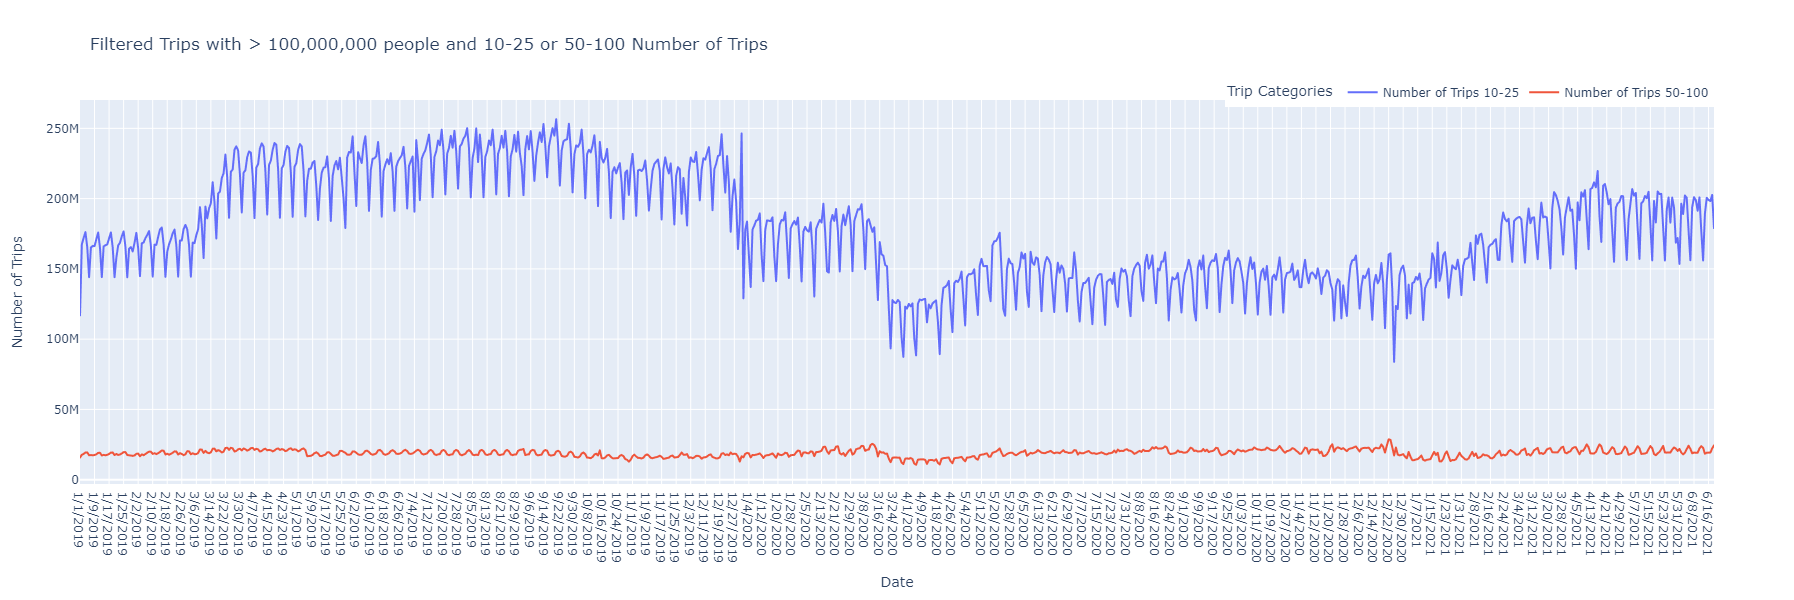

In [97]:
fig = px.line(compared, x='Date', y=['Number of Trips 10-25', 'Number of Trips 50-100'],
              title='Filtered Trips with > 100,000,000 people and 10-25 or 50-100 Number of Trips')

# Update layout for better visualization
fig.update_layout(xaxis_title='Date', yaxis_title='Number of Trips', legend_title='Trip Categories')
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="middle",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(height=600, width=1200)
fig.show()


##### Compare Time used for Sequential, 10 Processors, and 20 Processors

In [18]:
processors = ["10 Processors Q1.A", '20 Processors Q1.A',"Sequential Q1.A","10 Processors Q1.B",
              '20 Processors Q1.B',"Sequential Q1.B", "Sequential Q1.C","10 Processors Q1.C", '20 Processors Q1.C']
processing_time = [total_time_dask_10_1a, total_time_dask_20_1a, total_time_seq_1a,
                   total_time_dask_10, total_time_dask_20, total_time_seq_1b, total_time_seq, total_time_10, total_time_20]

In [19]:
# Define the processors and processing times
processors = ["10 Processors Q1.A", '20 Processors Q1.A', "Sequential Q1.A", "10 Processors Q1.B",
              '20 Processors Q1.B', "Sequential Q1.B", "Sequential Q1.C", "10 Processors Q1.C", '20 Processors Q1.C']
processors_level = ["10 Processors", '20 Processors', "Sequential", "10 Processors",
              '20 Processors', "Sequential", "Sequential", "10 Processors", '20 Processors']
processing_time = [total_time_dask_10_1a, total_time_dask_20_1a, total_time_seq_1a,
                   total_time_dask_10, total_time_dask_20, total_time_seq_1b, total_time_seq, total_time_10, total_time_20]

# Create a DataFrame
df = pd.DataFrame({'Processor': processors,'Level':processors_level, 'Processing Time (seconds)': processing_time})

# show processing times
df

,Processor,Level,Processing Time (seconds)
0,10 Processors Q1.A,10 Processors,42.18
1,20 Processors Q1.A,20 Processors,39.51
2,Sequential Q1.A,Sequential,32.17
3,10 Processors Q1.B,10 Processors,5.68
4,20 Processors Q1.B,20 Processors,13.77
5,Sequential Q1.B,Sequential,9.60
6,Sequential Q1.C,Sequential,0.08
7,10 Processors Q1.C,10 Processors,0.06
8,20 Processors Q1.C,20 Processors,0.05


In [20]:
df.to_csv("processing times.csv", index = False)

In [21]:
# Compare mean processing times
mean_times = pd.DataFrame(df.groupby('Level')['Processing Time (seconds)'].mean())
print("\nMean Processing Times:")
mean_times


Mean Processing Times:


,Processing Time (seconds)
Level,
10 Processors,15.973333
20 Processors,17.776667
Sequential,13.950000


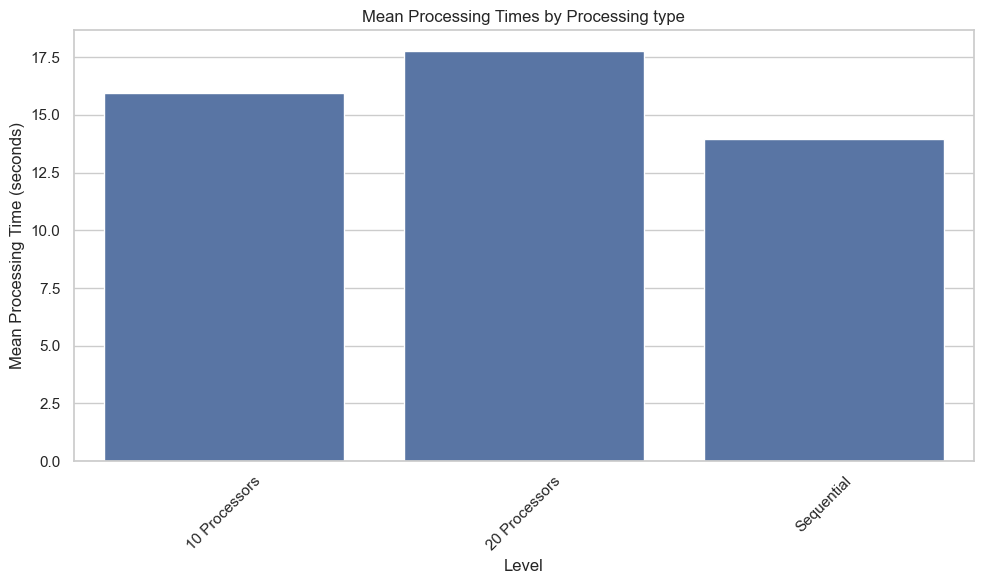

CPU times: total: 688 ms
Wall time: 778 ms


In [22]:
%%time
#bar chart for mean processing times
mean_times.reset_index(inplace=True)  # Reset index

#Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Level', y='Processing Time (seconds)', data=mean_times)
plt.title('Mean Processing Times by Processing type')
plt.xlabel('Level')
plt.ylabel('Mean Processing Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show
plt.show()


#### 1E - Modeling

##### Trips by Distance (Number of Trips)

In [23]:
data_distance = dd.read_csv('data/Trips_by_Distance.csv', assume_missing=True, dtype={'County Name': 'object', 'State Postal Code': 'object'})
#subset data for use
selected_columns = [
        'Population Not Staying at Home',
        'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
        'Number of Trips 5-10', 'Number of Trips 10-25',
        'Number of Trips 25-50', 'Number of Trips 50-100',
        'Number of Trips 100-250', 'Number of Trips 250-500',
        'Number of Trips >=500', 'Week'
    ]

data_selected = data_distance[selected_columns]

In [24]:
###test for linearity
# Compute Pearson correlation coefficients
correlation_y_x = data_selected.corr(method='pearson').compute()

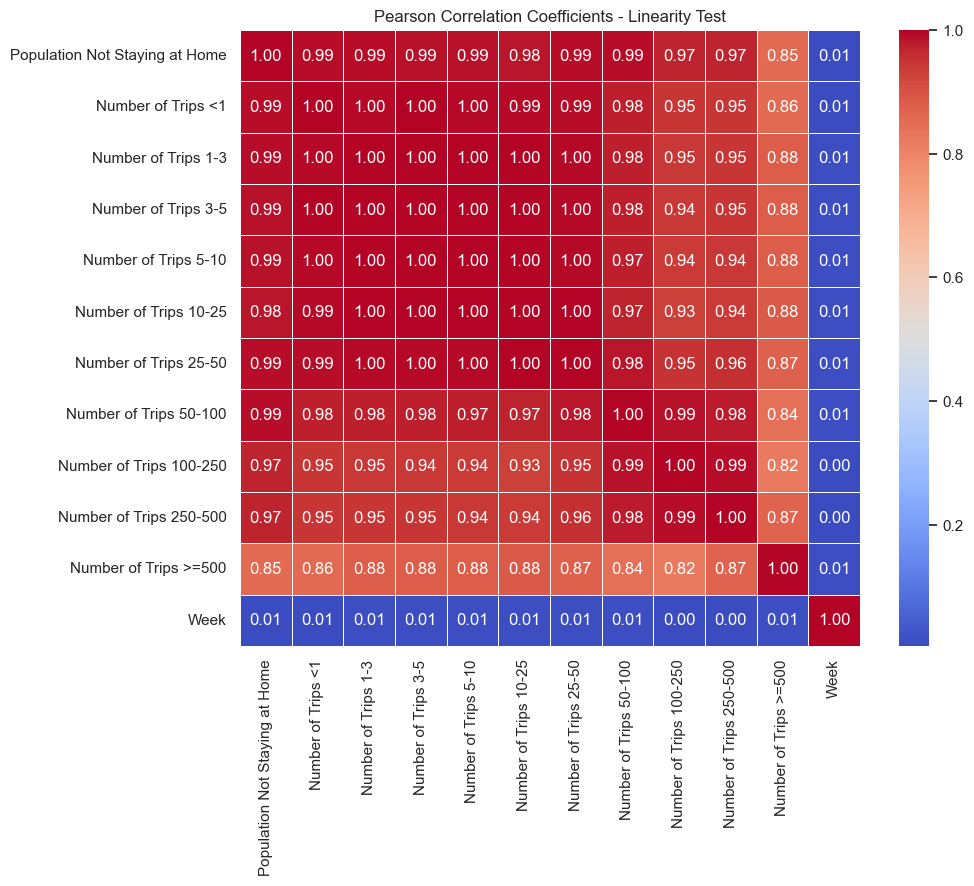

CPU times: total: 1.05 s
Wall time: 1.8 s


In [25]:
%%time
#heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_y_x, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Coefficients - Linearity Test')
plt.show()

> Since all the variables _'Number of Trips <1',
       'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10',
       'Number of Trips 10-25', 'Number of Trips 25-50',
       'Number of Trips 50-100', 'Number of Trips 100-250',
       'Number of Trips 250-500', 'Number of Trips >=500'_ are highly correlated with each other and with Population Not Staying at Home ( target variable), this will present the problem of multicollinearity if all variables are used in the model. Therefore only the variable "Number of Trips 50-100" which has the highes correlation is used along side week number as predictors.

In [26]:
%%time
#get the variables to use
vars = ['Population Not Staying at Home', 'Number of Trips 50-100', 'Week']
#subset
datax = data_selected[vars]
#drop nan
datax = datax.dropna().compute()
#get x
X = datax[['Number of Trips 50-100', 'Week']]
#get y 
y = datax['Population Not Staying at Home']
print("X Shape:", X.shape)
print("\ny Shape:", y.shape)
#obtain x and y values
dask_x = X.values
dask_y = y.values

X Shape: (1035625, 2)

y Shape: (1035625,)
CPU times: total: 7.67 s
Wall time: 9.2 s


#### 10 Processors

In [27]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.3, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared = round(r2_score(y_test, y_pred), 4)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared)
print("RMSE:", rmse)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_70 = round(end_time - start_time, 2)

R-Squared: 0.9783
RMSE: 1139104.8422
CPU times: total: 8.61 s
Wall time: 56.1 s


##### Increase Training Size

In [28]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (90:10 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.1, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared1 = round(r2_score(y_test, y_pred), 4)
rmse1 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared1)
print("RMSE:", rmse1)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_90 = round(end_time - start_time, 2)

R-Squared: 0.9754
RMSE: 1201830.882
CPU times: total: 6.98 s
Wall time: 50.4 s


In [29]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.2, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared2 = round(r2_score(y_test, y_pred), 4)
rmse2 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared2)
print("RMSE:", rmse2)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_80 = round(end_time - start_time, 2)

R-Squared: 0.9759
RMSE: 1192543.3382
CPU times: total: 7.97 s
Wall time: 1min 1s


##### Reduce the training size

In [30]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (60:40 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.4, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared3 = round(r2_score(y_test, y_pred), 4)
rmse3 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared3)
print("RMSE:", rmse3)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_60 = round(end_time - start_time, 2)

R-Squared: 0.9783
RMSE: 1114474.4401
CPU times: total: 8.39 s
Wall time: 1min 7s


In [31]:
time_taken_10 = pd.DataFrame()
time_taken_10['Training Data Size (%)'] = [90, 80, 70, 60]
time_taken_10['Time taken'] = [lr_time_90, lr_time_80, lr_time_70, lr_time_60]
#save
time_taken_10 = time_taken_10.sort_values("Time taken", ascending = True)
time_taken_10.to_csv("distance/time taken model 10 processors.csv", index = False)

In [32]:
time_taken_10

,Training Data Size (%),Time taken
0,90,48.84
2,70,54.55
1,80,59.31
3,60,65.37


##### Plot actual vs predicted

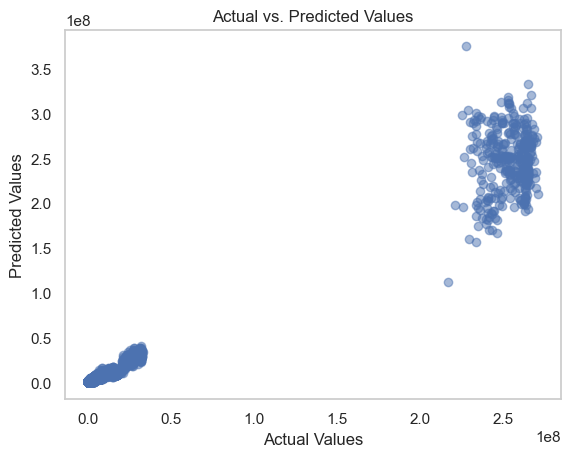

In [33]:
# Convert Dask DataFrames to Pandas DataFrames for plotting
y_test_pd = y_test
y_pred_pd = y_pred

# Plot actual vs. predicted values
plt.scatter(y_test_pd, y_pred_pd, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

##### Compare performance by data size

In [34]:
#data size
data_size = ['60%', '70%', '80%','90%']
r_squareds = [r_squared, r_squared1, r_squared2, r_squared3]
#rmses
rmses = [rmse, rmse1, rmse2, rmse3]
#dataframe
df_10_processors = pd.DataFrame({
    'Data Size': data_size,
    'R-Squared': r_squareds,
    'RMSE': [round(item, 2) for item in rmses]
})

# Sort DataFrame by RMSE
df_10_processors = df_10_processors.sort_values(by='RMSE')
df_10_processors

,Data Size,R-Squared,RMSE
3,90%,0.9783,1114474.44
0,60%,0.9783,1139104.84
2,80%,0.9759,1192543.34
1,70%,0.9754,1201830.88


In [35]:
df_10_processors.sort_values(by='RMSE').to_csv("distance/performance_10_proc.csv", index = False)

#### 20 Processors

In [36]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.3, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared = round(r2_score(y_test, y_pred), 4)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared)
print("RMSE:", rmse)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_70 = round(end_time - start_time, 2)

R-Squared: 0.9783
RMSE: 1139104.8422
CPU times: total: 20.3 s
Wall time: 1min 57s


##### Increase Training Size

In [37]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (90:10 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.1, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared1 = round(r2_score(y_test, y_pred), 4)
rmse1 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared1)
print("RMSE:", rmse1)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_90 = round(end_time - start_time, 2)

R-Squared: 0.9754
RMSE: 1201830.882
CPU times: total: 24 s
Wall time: 2min 17s


In [38]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.2, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared2 = round(r2_score(y_test, y_pred), 4)
rmse2 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared2)
print("RMSE:", rmse2)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_80 = round(end_time - start_time, 2)

R-Squared: 0.9759
RMSE: 1192543.3382
CPU times: total: 22.4 s
Wall time: 1min 50s


##### Reduce the training size

In [39]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (60:40 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.4, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared3 = round(r2_score(y_test, y_pred), 4)
rmse3 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared3)
print("RMSE:", rmse3)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_60 = round(end_time - start_time, 2)

R-Squared: 0.9783
RMSE: 1114474.4401
CPU times: total: 19 s
Wall time: 1min 46s


In [40]:
time_taken_20 = pd.DataFrame()
time_taken_20['Training Data Size (%)'] = [90, 80, 70, 60]
time_taken_20['Time taken'] = [lr_time_90, lr_time_80, lr_time_70, lr_time_60]
#save
time_taken_20 = time_taken_20.sort_values("Time taken", ascending = True)
time_taken_20.to_csv("distance/time taken model 20 processors.csv", index = False)

In [41]:
time_taken_20

,Training Data Size (%),Time taken
3,60,103.09
1,80,106.83
2,70,112.43
0,90,135.04


##### Plot actual vs predicted

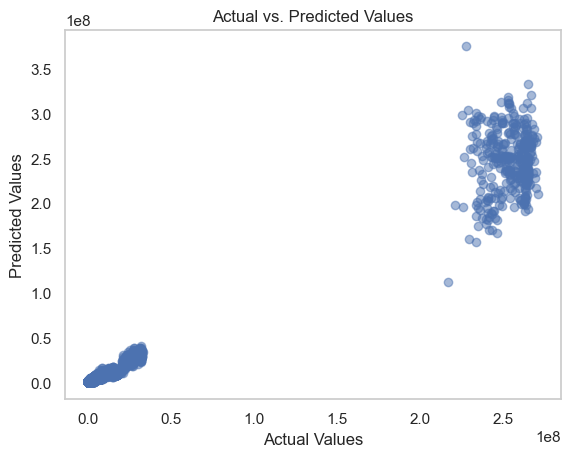

In [42]:
# Convert Dask DataFrames to Pandas DataFrames for plotting
y_test_pd = y_test
y_pred_pd = y_pred

# Plot actual vs. predicted values
plt.scatter(y_test_pd, y_pred_pd, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

##### Compare performance by data size

In [43]:
#data size
data_size = ['60%', '70%', '80%','90%']
r_squareds = [r_squared, r_squared1, r_squared2, r_squared3]
#rmses
rmses = [rmse, rmse1, rmse2, rmse3]
#dataframe
df_20_processors = pd.DataFrame({
    'Data Size': data_size,
    'R-Squared': r_squareds,
    'RMSE': [round(item, 2) for item in rmses]
})

# Sort DataFrame by RMSE
df_20_processors.sort_values(by='RMSE')

,Data Size,R-Squared,RMSE
3,90%,0.9783,1114474.44
0,60%,0.9783,1139104.84
2,80%,0.9759,1192543.34
1,70%,0.9754,1201830.88


In [44]:
df_20_processors.sort_values(by='RMSE').to_csv("distance/performance_20_proc.csv", index = False)

#### Sequential

In [45]:
%%time
start_time = time()
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.3, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared = round(r2_score(y_test, y_pred), 4)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared)
print("RMSE:", rmse)
end_time = time()
lr_time_70 = round(end_time - start_time, 2)

R-Squared: 0.9783
RMSE: 1139104.8422
CPU times: total: 2.19 s
Wall time: 3.47 s


##### Increase Training Size

In [46]:
%%time
start_time = time()
# Split the data into training and testing sets (90:10 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.1, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared1 = round(r2_score(y_test, y_pred), 4)
rmse1 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared1)
print("RMSE:", rmse1)
end_time = time()
lr_time_90 = round(end_time - start_time, 2)

R-Squared: 0.9754
RMSE: 1201830.882
CPU times: total: 2.44 s
Wall time: 4.05 s


In [47]:
%%time
start_time = time()
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.2, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared2 = round(r2_score(y_test, y_pred), 4)
rmse2 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared2)
print("RMSE:", rmse2)
end_time = time()
lr_time_80 = round(end_time - start_time, 2)

R-Squared: 0.9759
RMSE: 1192543.3382
CPU times: total: 2.81 s
Wall time: 3.82 s


##### Reduce the training size

In [48]:
%%time
start_time = time()
# Split the data into training and testing sets (60:40 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.4, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared3 = round(r2_score(y_test, y_pred), 4)
rmse3 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared3)
print("RMSE:", rmse3)
end_time = time()
lr_time_60 = round(end_time - start_time, 2)

R-Squared: 0.9783
RMSE: 1114474.4401
CPU times: total: 1.3 s
Wall time: 3.15 s


In [49]:
time_taken_sequential = pd.DataFrame()
time_taken_sequential['Training Data Size (%)'] = [90, 80, 70, 60]
time_taken_sequential['Time taken'] = [lr_time_90, lr_time_80, lr_time_70, lr_time_60]
#save
time_taken_sequential = time_taken_sequential.sort_values("Time taken", ascending = True)
time_taken_sequential.to_csv("distance/time taken model sequential processors.csv", index = False)

In [50]:
time_taken_sequential

,Training Data Size (%),Time taken
3,60,3.15
2,70,3.47
1,80,3.82
0,90,4.05


##### Plot actual vs predicted

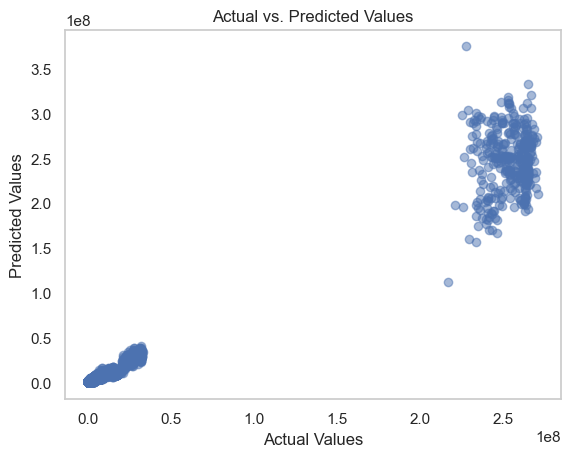

In [51]:
# Convert Dask DataFrames to Pandas DataFrames for plotting
y_test_pd = y_test
y_pred_pd = y_pred
# Plot actual vs. predicted values
plt.scatter(y_test_pd, y_pred_pd, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

##### Compare performance by data size

In [52]:
#data size
data_size = ['60%', '70%', '80%','90%']
r_squareds = [r_squared, r_squared1, r_squared2, r_squared3]
#rmses
rmses = [rmse, rmse1, rmse2, rmse3]
#dataframe
df_sequential = pd.DataFrame({
    'Data Size': data_size,
    'R-Squared': r_squareds,
    'RMSE': [round(item, 2) for item in rmses]
})

# Sort DataFrame by RMSE
df_sequential.sort_values(by='RMSE')

,Data Size,R-Squared,RMSE
3,90%,0.9783,1114474.44
0,60%,0.9783,1139104.84
2,80%,0.9759,1192543.34
1,70%,0.9754,1201830.88


In [53]:
df_sequential.sort_values(by='RMSE').to_csv("distance/performance_sequential.csv", index = False)

### Trips by Distance (Full Data)

In [54]:
#read and process data
full_data, time_taken = read_data("data/Trips_Full Data.csv")
#confirm data is processed with no missing values
missing_full = full_data.isnull().sum().compute()
missing_full

Month of Date                 0
Week of Date                  0
Year of Date                  0
Level                         0
Date                          0
Week Ending Date              0
Trips <1 Mile                 0
People Not Staying at Home    0
Population Staying at Home    0
Trips                         0
Trips 1-25 Miles              0
Trips 1-3 Miles               0
Trips 10-25 Miles             0
Trips 100-250 Miles           0
Trips 100+ Miles              0
Trips 25-100 Miles            0
Trips 25-50 Miles             0
Trips 250-500 Miles           0
Trips 3-5 Miles               0
Trips 5-10 Miles              0
Trips 50-100 Miles            0
Trips 500+ Miles              0
dtype: int64

In [55]:
#subset data for use
selected_columns = full_data.select_dtypes(include='number').columns.to_list()
selected_columns.remove('Year of Date')
selected_columns.remove("People Not Staying at Home")
data_sel = full_data[selected_columns ]

In [56]:
###test for linearity
# Compute Pearson correlation coefficients
corr_matrix = data_sel.corr(method='pearson').compute()

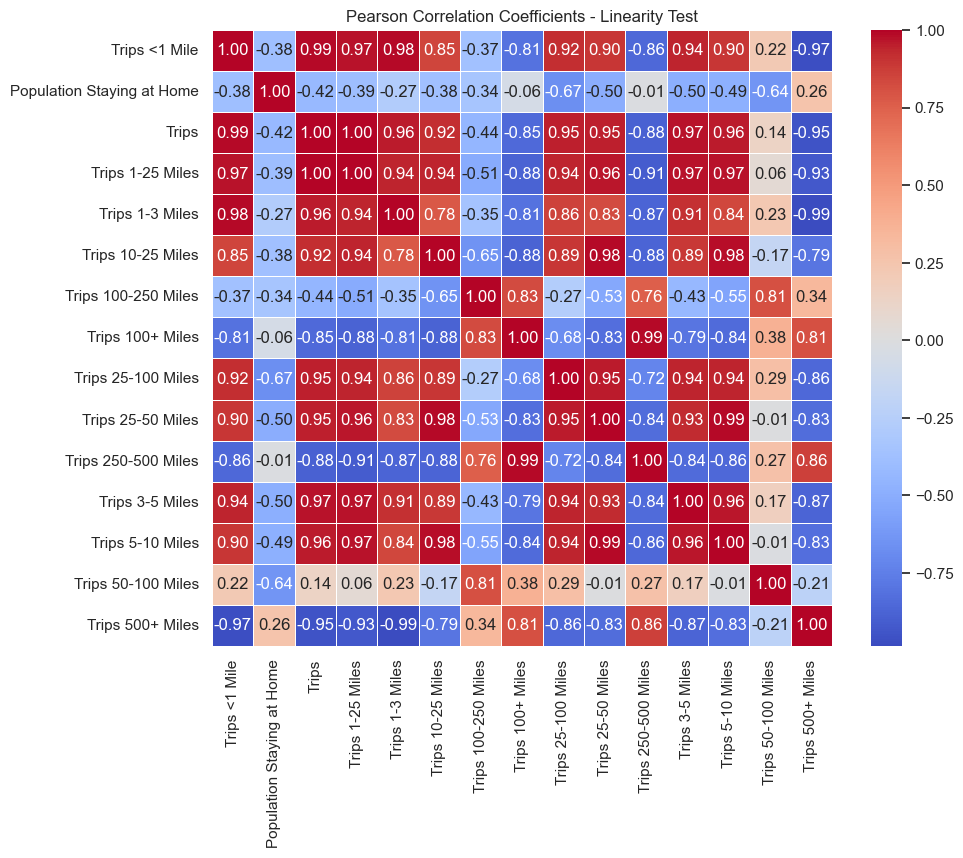

CPU times: total: 1.75 s
Wall time: 3.29 s


In [57]:
%%time
#heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Coefficients - Linearity Test')
plt.show()

##### Drop higly correlated variables

In [58]:
#Drop higly corrleated variables
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
data_selected = data_sel.drop(to_drop, axis=1)

In [59]:
%%time
#get the variables to use
vars = data_selected.compute().columns.to_list()

#subset
datax = data_sel[vars]

#drop nan
datax = datax.dropna().compute()
#get x
X = datax[vars]
#get y 
y = datax['Population Staying at Home']
print("X Shape:", X.shape)
print("\ny Shape:", y.shape)
#obtain x and y values
dask_x = X.values
dask_y = y.values

X Shape: (7, 7)

y Shape: (7,)
CPU times: total: 15.6 ms
Wall time: 114 ms


#### 10 Processors

In [60]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.3, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared = round(r2_score(y_test, y_pred), 4)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared)
print("RMSE:", rmse)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_70 = round(end_time - start_time, 2)

R-Squared: -2.1119
RMSE: 10185953.4187
CPU times: total: 7.03 s
Wall time: 43.1 s


##### Increase Training Size

In [61]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (90:10 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.1, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared1 = round(r2_score(y_test, y_pred), 4)
rmse1 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared1)
print("RMSE:", rmse1)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_90 = round(end_time - start_time, 2)

R-Squared: nan
RMSE: 10155455.7257
CPU times: total: 5.86 s
Wall time: 41.1 s


In [62]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.2, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared2 = round(r2_score(y_test, y_pred), 4)
rmse2 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared2)
print("RMSE:", rmse2)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_80 = round(end_time - start_time, 2)

R-Squared: -23.2018
RMSE: 9336353.07
CPU times: total: 7.97 s
Wall time: 46.2 s


##### Reduce the training size

In [63]:
%%time
start_time = time()
client = Client( n_workers = 10)  #  number of processors
# Split the data into training and testing sets (60:40 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.4, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared3 = round(r2_score(y_test, y_pred), 4)
rmse3 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared3)
print("RMSE:", rmse3)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_60 = round(end_time - start_time, 2)

R-Squared: -2.1119
RMSE: 10185953.4187
CPU times: total: 7.69 s
Wall time: 48.9 s


In [64]:
time_taken_10 = pd.DataFrame()
time_taken_10['Training Data Size (%)'] = [90, 80, 70, 60]
time_taken_10['Time taken'] = [lr_time_90, lr_time_80, lr_time_70, lr_time_60]
#save
time_taken_10 = time_taken_10.sort_values("Time taken", ascending = True)
time_taken_10.to_csv("full_data/time taken model 10 processors.csv", index = False)

In [65]:
time_taken_10

,Training Data Size (%),Time taken
0,90,39.51
2,70,41.60
1,80,44.48
3,60,46.99


##### Plot actual vs predicted

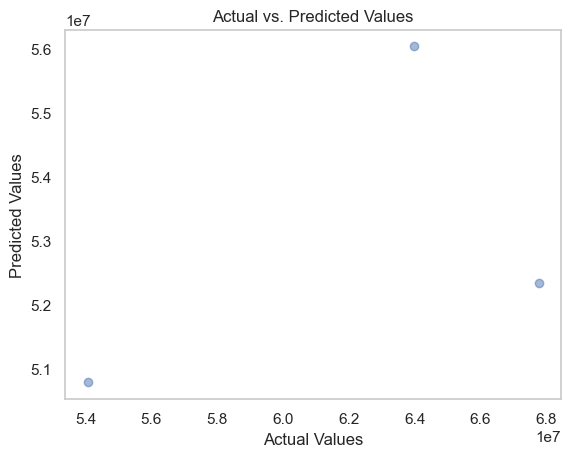

In [66]:
# Convert Dask DataFrames to Pandas DataFrames for plotting
y_test_pd = y_test
y_pred_pd = y_pred

# Plot actual vs. predicted values
plt.scatter(y_test_pd, y_pred_pd, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

##### Compare performance by data size

In [67]:
#data size
data_size = ['60%', '70%', '80%','90%']
r_squareds = [r_squared, r_squared1, r_squared2, r_squared3]
#rmses
rmses = [rmse, rmse1, rmse2, rmse3]
#dataframe
df_10_processors = pd.DataFrame({
    'Data Size': data_size,
    'R-Squared': r_squareds,
    'RMSE': [round(item, 2) for item in rmses]
})

# Sort DataFrame by RMSE
df_10_processors = df_10_processors.sort_values(by='RMSE')
df_10_processors

,Data Size,R-Squared,RMSE
2,80%,-23.2018,9336353.07
1,70%,NaN,10155455.73
0,60%,-2.1119,10185953.42
3,90%,-2.1119,10185953.42


In [92]:
df_10_processors.sort_values(by='RMSE').to_csv("full_data/performance_10_proc.csv", index = False)

#### 20 Processors

In [69]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.3, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared = round(r2_score(y_test, y_pred), 4)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared)
print("RMSE:", rmse)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_70 = round(end_time - start_time, 2)

R-Squared: -2.1119
RMSE: 10185953.4187
CPU times: total: 14.8 s
Wall time: 1min 22s


##### Increase Training Size

In [70]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (90:10 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.1, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared1 = round(r2_score(y_test, y_pred), 4)
rmse1 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared1)
print("RMSE:", rmse1)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_90 = round(end_time - start_time, 2)

R-Squared: nan
RMSE: 10155455.7257
CPU times: total: 14.6 s
Wall time: 1min 17s


In [71]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.2, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared2 = round(r2_score(y_test, y_pred), 4)
rmse2 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared2)
print("RMSE:", rmse2)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_80 = round(end_time - start_time, 2)

R-Squared: -23.2018
RMSE: 9336353.07
CPU times: total: 17.3 s
Wall time: 1min 40s


##### Reduce the training size

In [72]:
%%time
start_time = time()
client = Client( n_workers = 20)  #  number of processors
# Split the data into training and testing sets (60:40 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.4, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared3 = round(r2_score(y_test, y_pred), 4)
rmse3 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared3)
print("RMSE:", rmse3)
end_time = time()
# Shutdown Dask client
client.close()
lr_time_60 = round(end_time - start_time, 2)

R-Squared: -2.1119
RMSE: 10185953.4187
CPU times: total: 13.9 s
Wall time: 1min 16s


In [73]:
time_taken_20 = pd.DataFrame()
time_taken_20['Training Data Size (%)'] = [90, 80, 70, 60]
time_taken_20['Time taken'] = [lr_time_90, lr_time_80, lr_time_70, lr_time_60]
#save
time_taken_20_full = time_taken_20.sort_values("Time taken", ascending = True)
time_taken_20_full.to_csv("full_data/time taken model 20 processors.csv", index = False)

In [74]:
time_taken_20_full

,Training Data Size (%),Time taken
3,60,71.91
0,90,74.41
2,70,79.67
1,80,96.73


##### Plot actual vs predicted

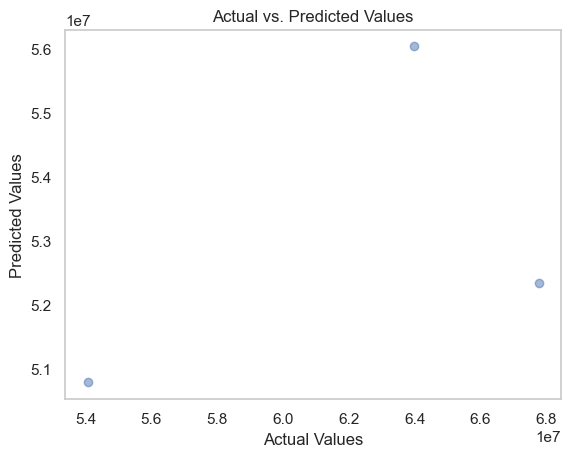

In [75]:
# Convert Dask DataFrames to Pandas DataFrames for plotting
y_test_pd = y_test
y_pred_pd = y_pred

# Plot actual vs. predicted values
plt.scatter(y_test_pd, y_pred_pd, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

##### Compare performance by data size

In [76]:
#data size
data_size = ['60%', '70%', '80%','90%']
r_squareds = [r_squared, r_squared1, r_squared2, r_squared3]
#rmses
rmses = [rmse, rmse1, rmse2, rmse3]
#dataframe
df_20_processors = pd.DataFrame({
    'Data Size': data_size,
    'R-Squared': r_squareds,
    'RMSE': [round(item, 2) for item in rmses]
})

# Sort DataFrame by RMSE
df_20_processors.sort_values(by='RMSE')

,Data Size,R-Squared,RMSE
2,80%,-23.2018,9336353.07
1,70%,NaN,10155455.73
0,60%,-2.1119,10185953.42
3,90%,-2.1119,10185953.42


In [77]:
df_20_processors.sort_values(by='RMSE').to_csv("full_data/performance_20_proc.csv", index = False)

#### Sequential

In [78]:
%%time
start_time = time()
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.3, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared = round(r2_score(y_test, y_pred), 4)
rmse = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared)
print("RMSE:", rmse)
end_time = time()
lr_time_70 = round(end_time - start_time, 2)

R-Squared: -2.1119
RMSE: 10185953.4187
CPU times: total: 78.1 ms
Wall time: 85.4 ms


##### Increase Training Size

In [79]:
%%time
start_time = time()
# Split the data into training and testing sets (90:10 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.1, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared1 = round(r2_score(y_test, y_pred), 4)
rmse1 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared1)
print("RMSE:", rmse1)
end_time = time()
lr_time_90 = round(end_time - start_time, 2)

R-Squared: nan
RMSE: 10155455.7257
CPU times: total: 0 ns
Wall time: 82.9 ms


In [80]:
%%time
start_time = time()
# Split the data into training and testing sets (70:30 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.2, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared2 = round(r2_score(y_test, y_pred), 4)
rmse2 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared2)
print("RMSE:", rmse2)
end_time = time()
lr_time_80 = round(end_time - start_time, 2)

R-Squared: -23.2018
RMSE: 9336353.07
CPU times: total: 31.2 ms
Wall time: 74.7 ms


##### Reduce the training size

In [81]:
%%time
start_time = time()
# Split the data into training and testing sets (60:40 ratio)
X_train, X_test, y_train, y_test = train_test_split(dask_x, dask_y, test_size=0.4, random_state=42, shuffle = True)
#fit model
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
#make predictions on test data
y_pred = lr.predict(X_test)
#evaluate the model
# Evaluate R-squared and RMSE
r_squared3 = round(r2_score(y_test, y_pred), 4)
rmse3 = round(mean_squared_error(y_test, y_pred, squared=False), 4)
print("R-Squared:", r_squared3)
print("RMSE:", rmse3)
end_time = time()
lr_time_60 = round(end_time - start_time, 2)

R-Squared: -2.1119
RMSE: 10185953.4187
CPU times: total: 109 ms
Wall time: 115 ms


In [82]:
time_taken_sequential = pd.DataFrame()
time_taken_sequential['Training Data Size (%)'] = [90, 80, 70, 60]
time_taken_sequential['Time taken'] = [lr_time_90, lr_time_80, lr_time_70, lr_time_60]
#save
time_taken_sequential = time_taken_sequential.sort_values("Time taken", ascending = True)
time_taken_sequential.to_csv("full_data/time taken model sequential processors.csv", index = False)

In [83]:
time_taken_sequential

,Training Data Size (%),Time taken
1,80,0.07
0,90,0.08
2,70,0.08
3,60,0.12


##### Plot actual vs predicted

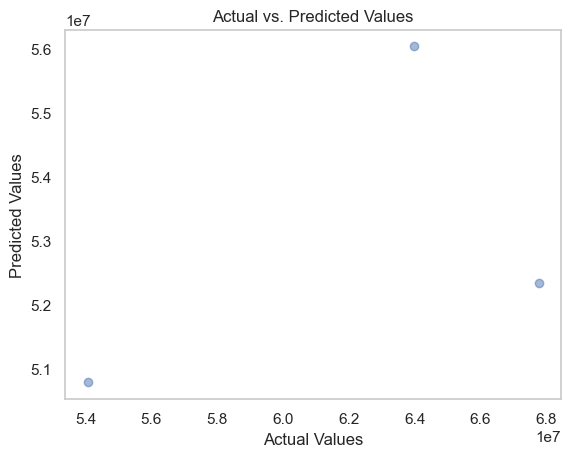

In [84]:
# Convert Dask DataFrames to Pandas DataFrames for plotting
y_test_pd = y_test
y_pred_pd = y_pred
# Plot actual vs. predicted values
plt.scatter(y_test_pd, y_pred_pd, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

##### Compare performance by data size

In [85]:
#data size
data_size = ['60%', '70%', '80%','90%']
r_squareds = [r_squared, r_squared1, r_squared2, r_squared3]
#rmses
rmses = [rmse, rmse1, rmse2, rmse3]
#dataframe
df_sequential = pd.DataFrame({
    'Data Size': data_size,
    'R-Squared': r_squareds,
    'RMSE': [round(item, 2) for item in rmses]
})

# Sort DataFrame by RMSE
df_sequential.sort_values(by='RMSE')

,Data Size,R-Squared,RMSE
2,80%,-23.2018,9336353.07
1,70%,NaN,10155455.73
0,60%,-2.1119,10185953.42
3,90%,-2.1119,10185953.42


In [86]:
df_sequential.sort_values(by='RMSE').to_csv("full_data/performance_sequential.csv", index = False)

#### 1F - Visualization

##### Visualize to check for distribution

In [87]:
# Compute the data
computed_data = full_data.compute()

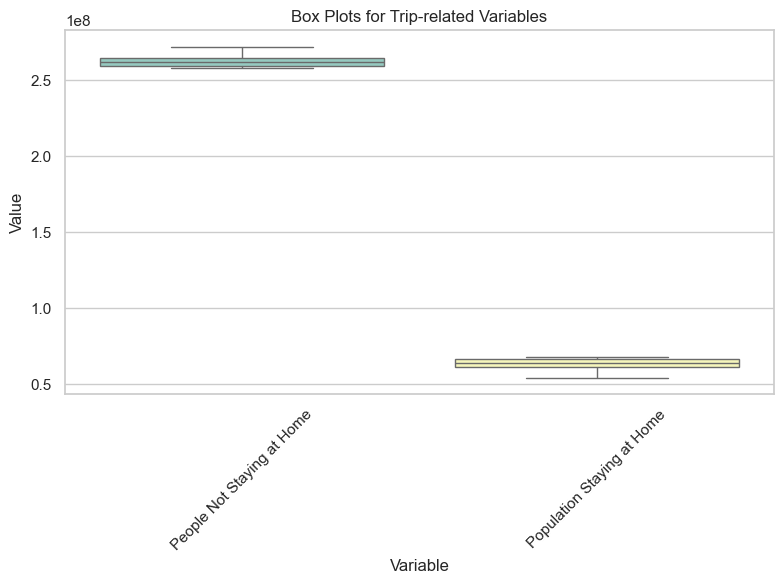

CPU times: total: 406 ms
Wall time: 680 ms


In [94]:
%%time
boxplot_variables = ['People Not Staying at Home', 'Population Staying at Home',
                       ]

# Select variables for the box plots
boxplot_data = computed_data[boxplot_variables]

# Melt DataFrame
melted_data = pd.melt(boxplot_data, var_name='Variable', value_name='Value')

#show plots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Variable', y='Value', data=melted_data, palette="Set3")
plt.title('Box Plots for Trip-related Variables')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

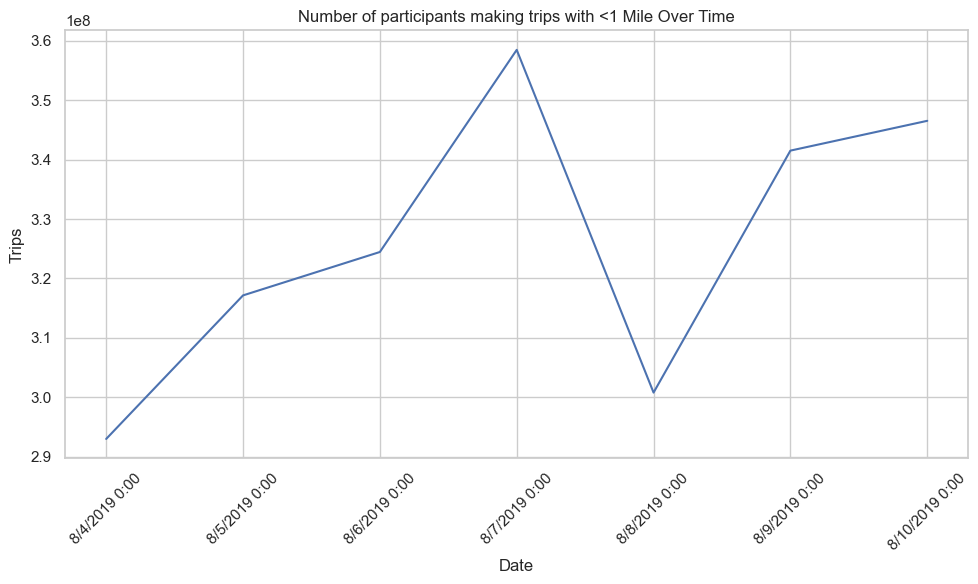

CPU times: total: 516 ms
Wall time: 1.14 s


In [89]:
%%time
plt.figure(figsize=(10, 6))
sns.lineplot(data=computed_data, x='Date', y='Trips <1 Mile')
plt.title('Number of participants making trips with <1 Mile Over Time')
plt.xlabel('Date')
plt.ylabel('Trips')
plt.xticks(rotation=45)
plt.tight_layout()
# Plot
plt.show()

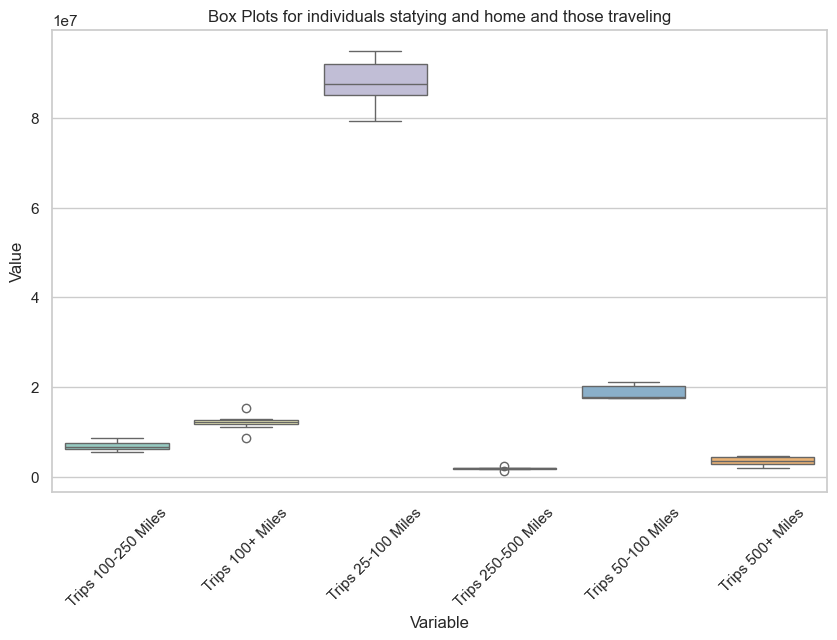

CPU times: total: 562 ms
Wall time: 834 ms


In [93]:
%%time
boxplot_variables = ['Trips <1 Mile', 'Trips 1-25 Miles', 'Trips 1-3 Miles','Trips 10-25 Miles','Trips 3-5 Miles',
                     'Trips 5-10 Miles','Trips 25-50 Miles']
# Melt
#melted_data = pd.melt(boxplot_data[boxplot_variables], var_name='Variable', value_name='Value')

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Variable', y='Value', data=melted_data, palette="Set3")
plt.title('Box Plots for individuals statying and home and those traveling')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45) 
plt.show()

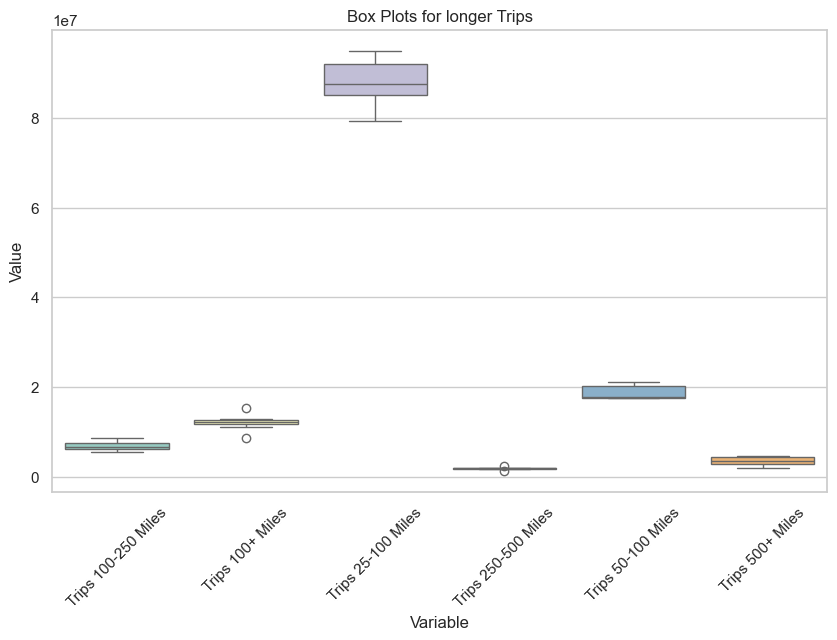

CPU times: total: 469 ms
Wall time: 1.04 s


In [91]:
%%time
variables = ['Trips 100-250 Miles', 'Trips 100+ Miles', 'Trips 25-100 Miles',
                       'Trips 250-500 Miles',  'Trips 50-100 Miles', 'Trips 500+ Miles'
                       ]

# Compute the data 
boxplot_data = full_data.compute()[variables]

# Melt the DataFrame
melted_data = pd.melt(boxplot_data, var_name='Variable', value_name='Value')


#Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Variable', y='Value', data=melted_data, palette="Set3")
plt.title('Box Plots for longer Trips')
plt.xlabel('Variable')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()